# Handwritten Text Recognition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import Important packages

In [ ]:
!pip install mxnet
!pip install mxboard
!pip3 install mxnet-mkl==1.6.0 numpy==1.23.1

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import mxnet as mx
from mxnet import gluon

In [ ]:
from dataset.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from utilities.expand_bounding_box import expand_bounding_box
from utilities.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from utilities.word_to_line import sort_bbs_line_by_line, crop_line_images
from utilities.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from utilities.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding
from utilities.beam_search import ctcBeamSearch

In [ ]:
!tar -xvf  '/content/drive/MyDrive/Final Year Project/Dataset/formsI-Z.tgz' -C '/content/dataset/iamdataset/form'
!tar -xvf  '/content/drive/MyDrive/Final Year Project/Dataset/formsE-H.tgz' -C '/content/dataset/iamdataset/form'
!tar -xvf  '/content/drive/MyDrive/Final Year Project/Dataset/formsA-D.tgz' -C '/content/dataset/iamdataset/form'
!tar -xvf  '/content/drive/MyDrive/Final Year Project/Dataset/xml.tgz' -C '/content/dataset/iamdataset/xml'
!tar -xvf  '/content/drive/MyDrive/Final Year Project/Dataset/lines.tgz' -C '/content/dataset/iamdataset/line'

Streaming output truncated to the last 5000 lines.
j06/j06-034/j06-034-06.png
j06/j06-034/j06-034-07.png
j06/j06-034/j06-034-08.png
j06/j06-034/j06-034-09.png
j06/j06-034/j06-034-10.png
j06/j06-051/
j06/j06-051/j06-051-00.png
j06/j06-051/j06-051-01.png
j06/j06-051/j06-051-02.png
j06/j06-051/j06-051-03.png
j06/j06-051/j06-051-04.png
j06/j06-051/j06-051-05.png
j06/j06-051/j06-051-06.png
j06/j06-051/j06-051-07.png
j06/j06-051/j06-051-08.png
j06/j06-051/j06-051-09.png
j06/j06-051/j06-051-10.png
j06/j06-056/
j06/j06-056/j06-056-00.png
j06/j06-056/j06-056-01.png
j06/j06-056/j06-056-02.png
j06/j06-056/j06-056-03.png
j06/j06-056/j06-056-04.png
j06/j06-056/j06-056-05.png
j06/j06-056/j06-056-06.png
j06/j06-056/j06-056-07.png
j06/j06-056/j06-056-08.png
j06/j06-056/j06-056-09.png
j06/j06-056/j06-056-10.png
j07/
j07/j07-000/
j07/j07-000/j07-000-00.png
j07/j07-000/j07-000-01.png
j07/j07-000/j07-000-02.png
j07/j07-000/j07-000-03.png
j07/j07-000/j07-000-04.png
j07/j07-000/j07-000-05.png
j07/j07-000/j0

In [ ]:
ctx=mx.cpu()

## 2. Create test dataset

In [ ]:
test_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=False)

/content/dataset/iamdataset/image_data-form-bb-form*.plk
Processing data:
Convert subject list


In [ ]:
#test_ds = IAMDataset("form_original", train=False) #stores as arrays along with output text

## 3. Plot Original Image

In [ ]:
print(len(test_ds))

232


In [ ]:
#Sets 4 images
figs_to_plot = 4
images = []
text = []

for i in range(0, figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, _ = test_ds[n]
    images.append(image)
    text.append(_)

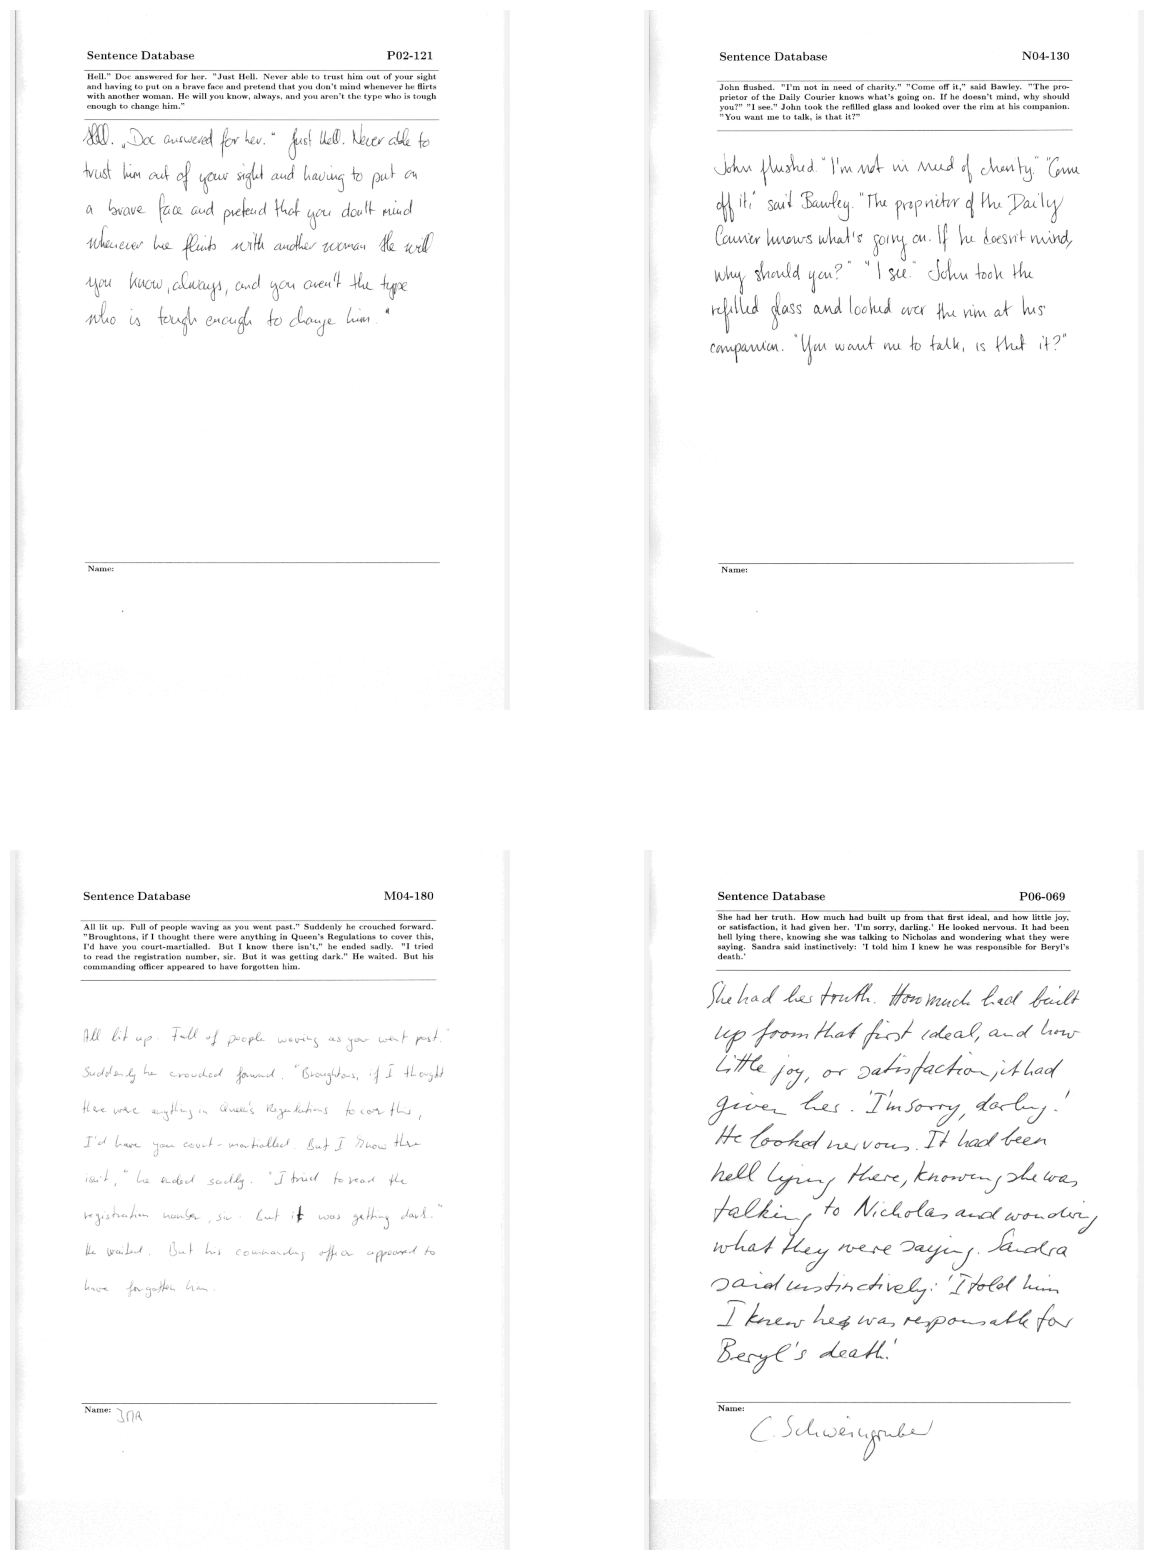

In [ ]:
#shows 4 images
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

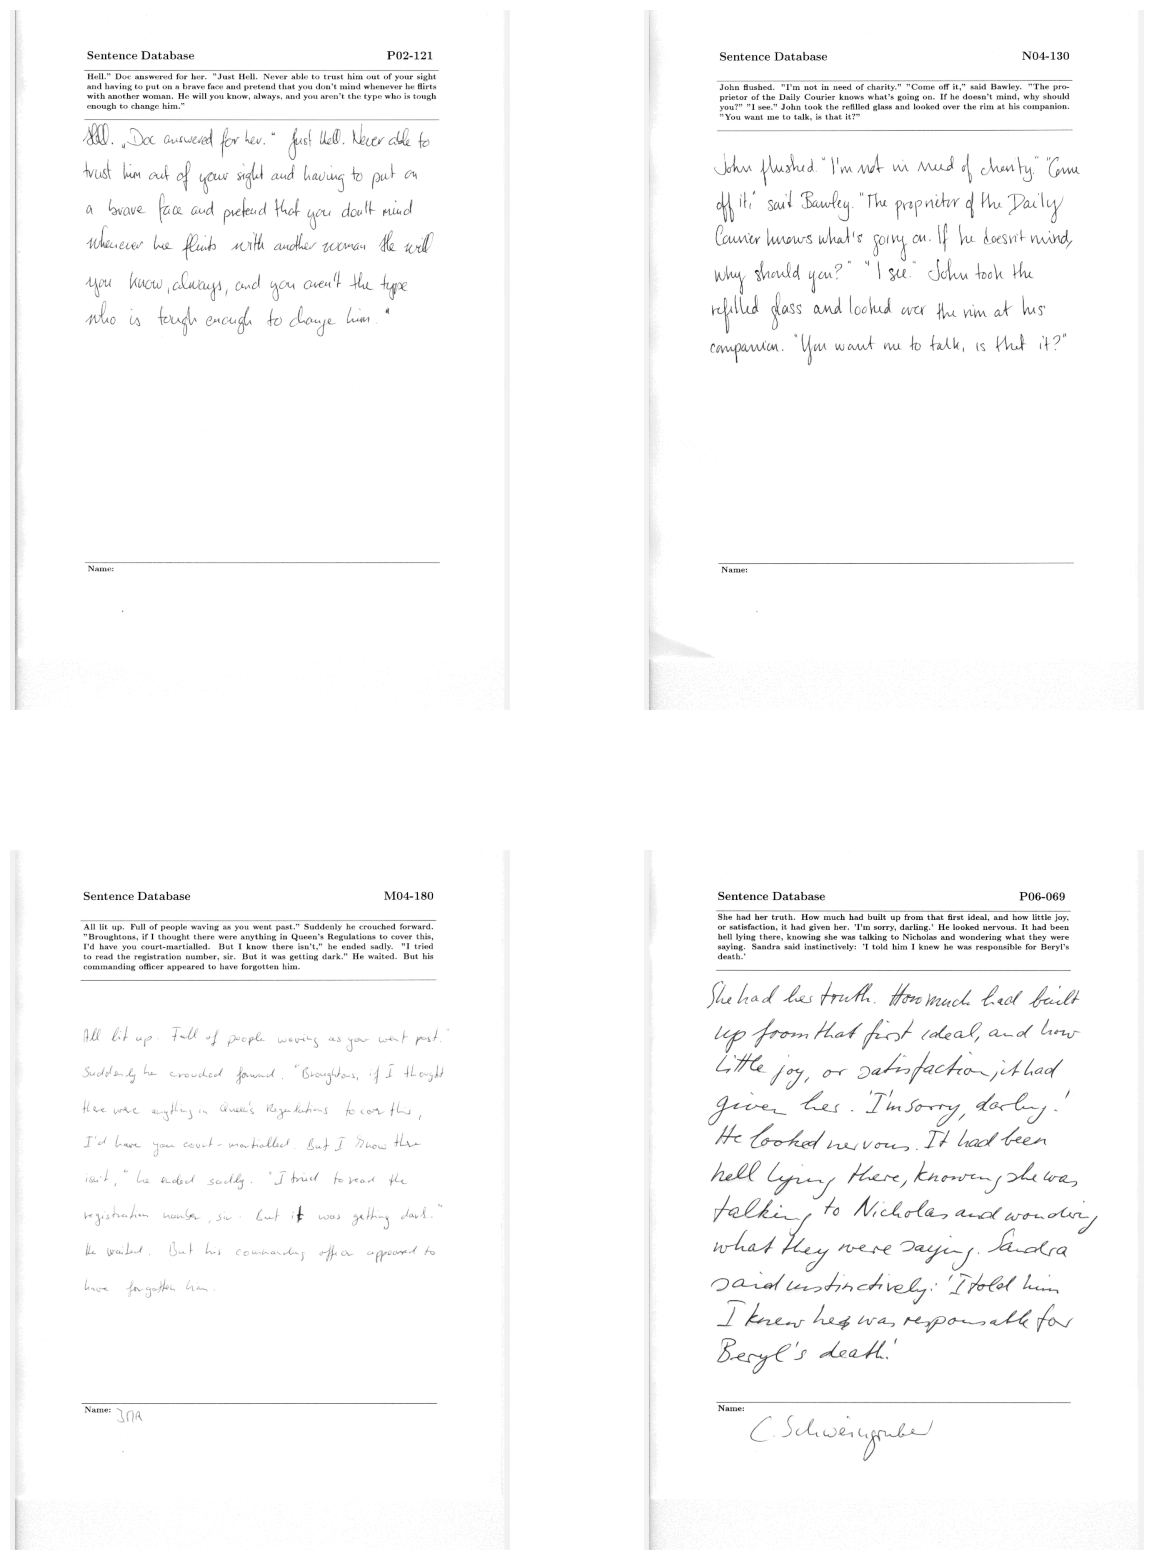

In [ ]:
#shows 4 images
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

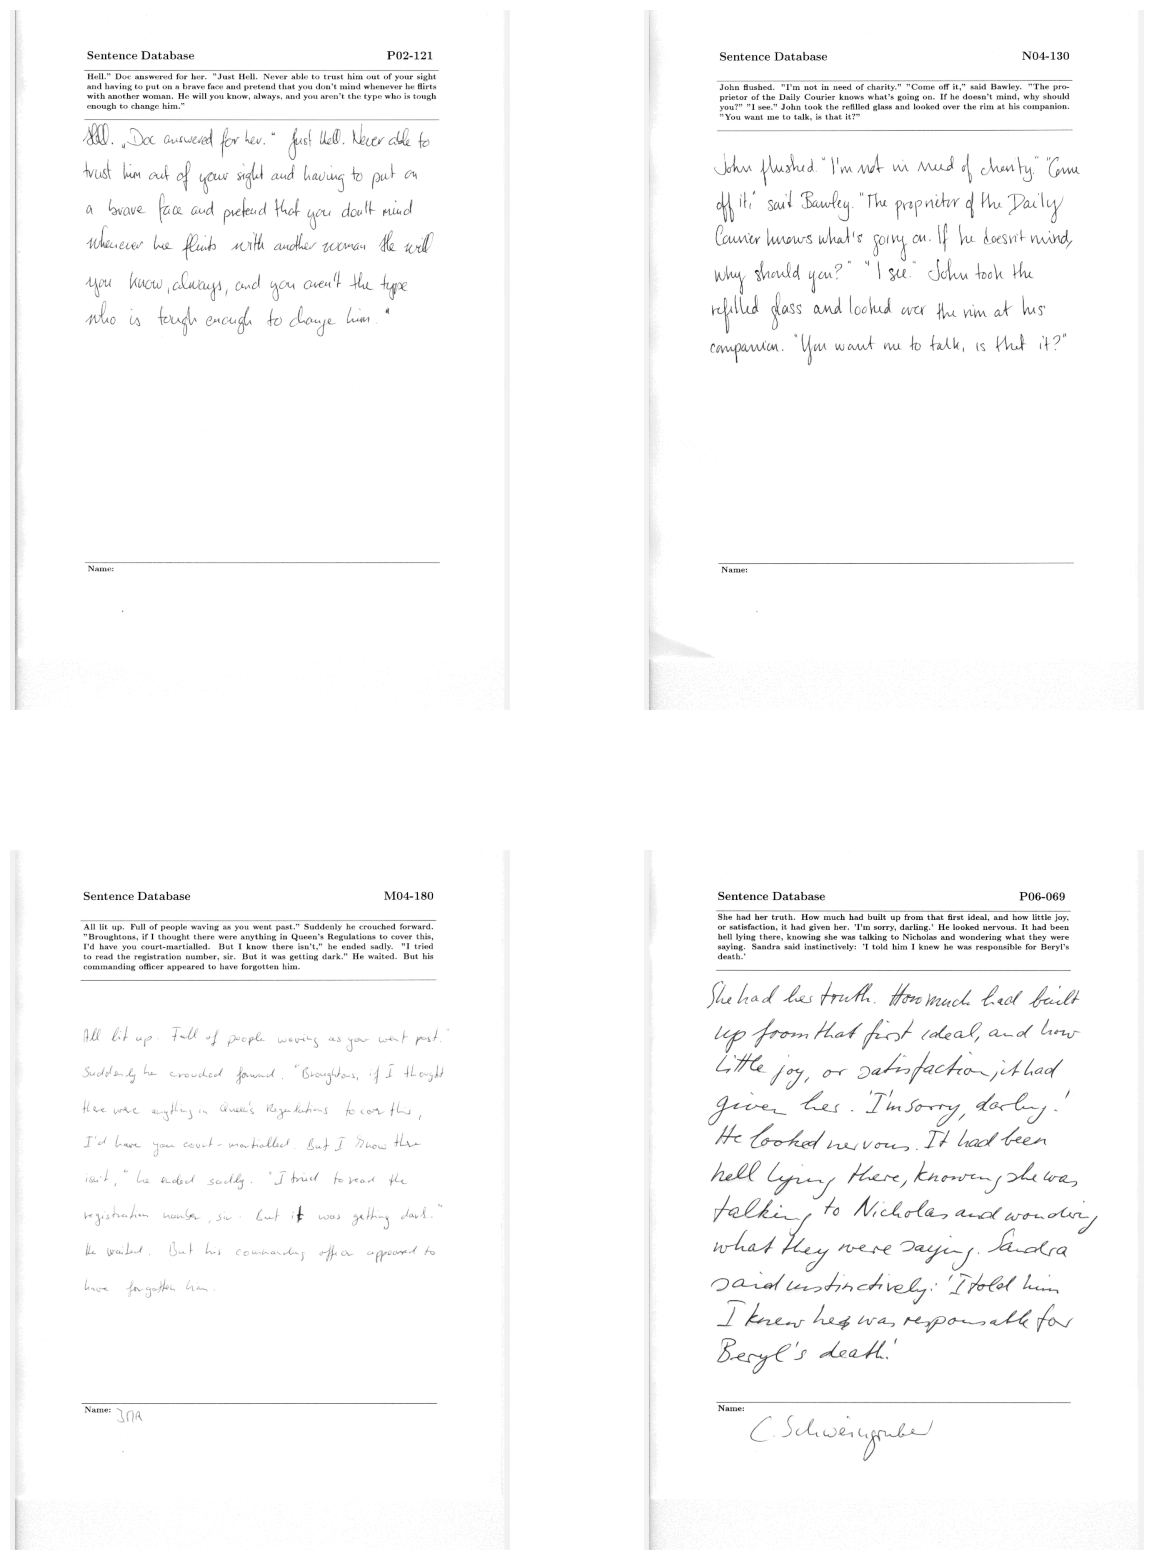

In [ ]:
#shows 4 images
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

## 4. Load Paragraph Segmentation Model

In [ ]:
sym = mx.sym.load_json(open('/content/drive/MyDrive/Final Year Project/Parameters/cnn_mse-symbol.json', 'r').read())
paragraph_segmentation_net = gluon.nn.SymbolBlock(outputs=sym, inputs=mx.sym.var('data'))
paragraph_segmentation_net.load_parameters('/content/drive/MyDrive/Final Year Project/Parameters/cnn_mse-0100.params', ctx=ctx)

/usr/local/lib/python3.10/dist-packages/mxnet/gluon/block.py:1389: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


In [ ]:
def paragraph_segmentation_transform(image, image_size):
    '''
    Function used for inference to resize the image for paragraph segmentation
    '''
    resized_image, _ = resize_image(image, image_size)

    resized_image = mx.nd.array(resized_image).expand_dims(axis=2)
    resized_image = mx.image.resize_short(resized_image, int(800/3))
    resized_image = resized_image.transpose([2, 0, 1])/255.
    resized_image = resized_image.expand_dims(axis=0)
    return resized_image

## 5. Run Paragraph Segmentation on test images

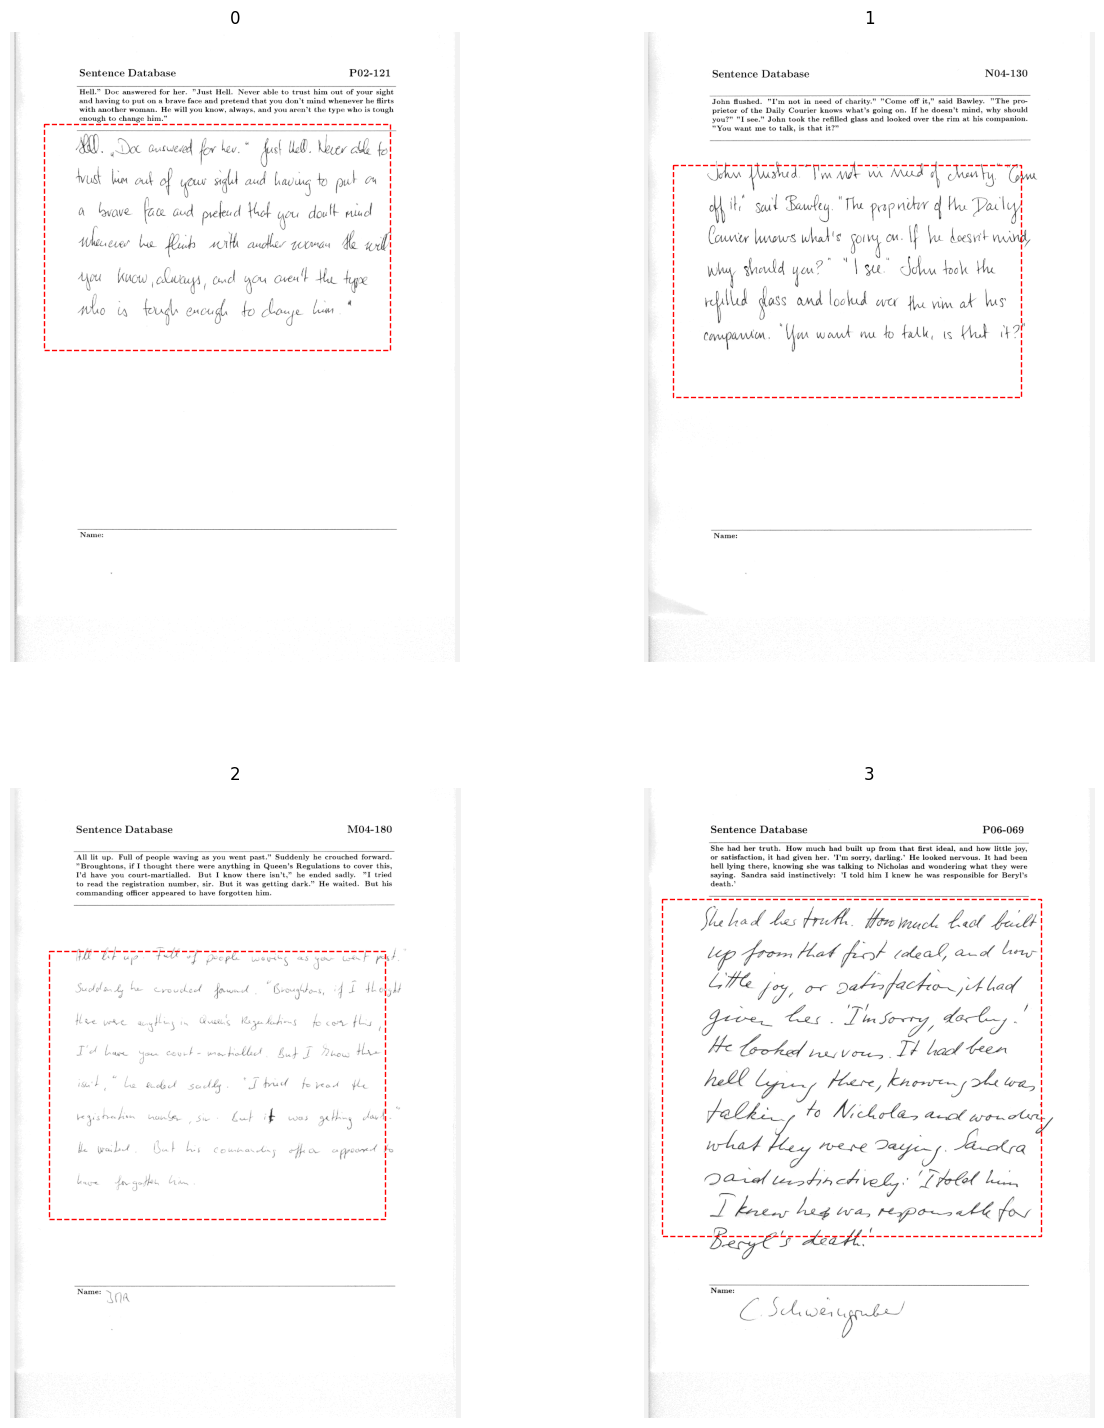

In [ ]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                           expand_bb_scale_y=0.03)
    predicted_bbs.append(bb_predicted)

    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

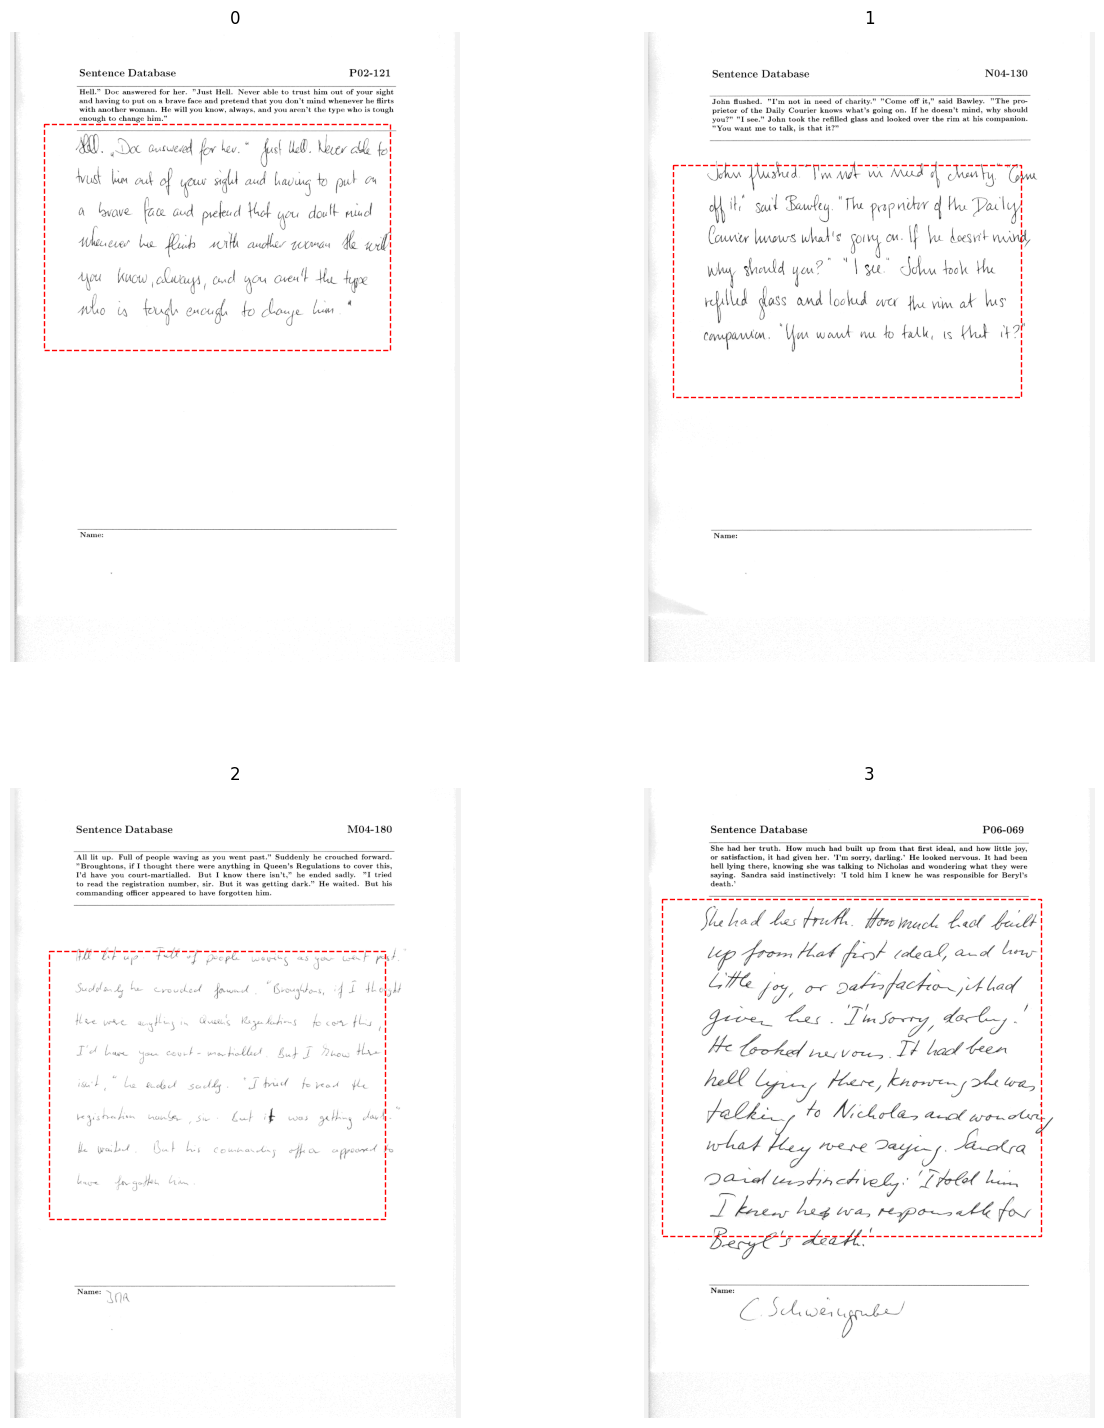

In [ ]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                           expand_bb_scale_y=0.03)
    predicted_bbs.append(bb_predicted)

    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

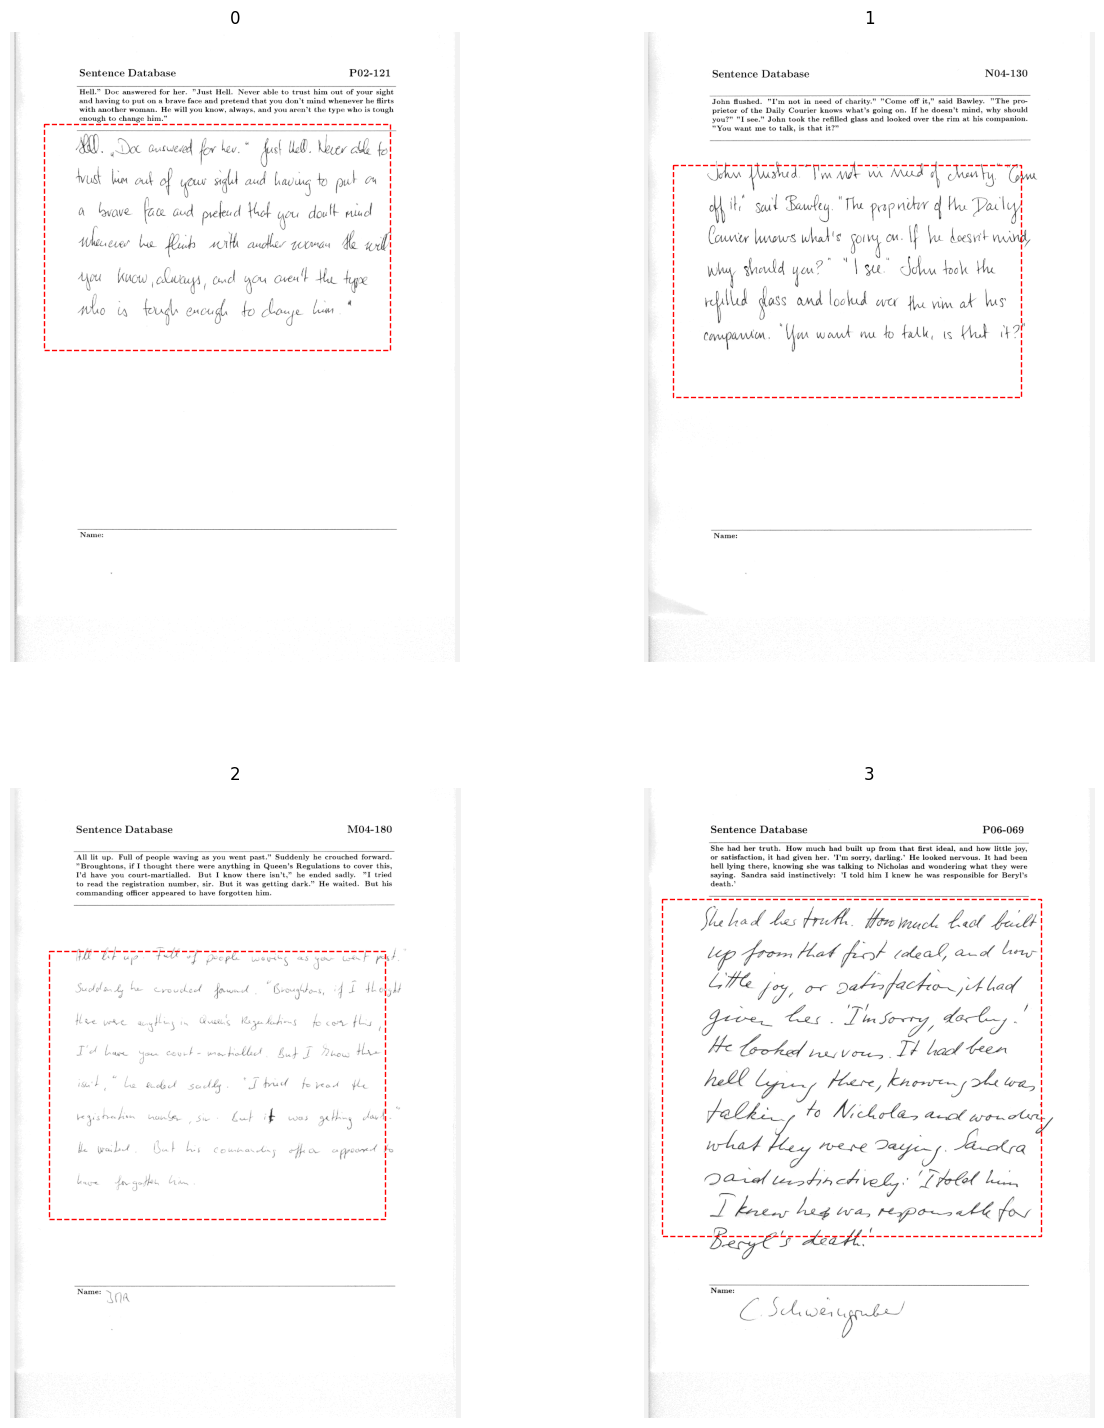

In [ ]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                           expand_bb_scale_y=0.03)
    predicted_bbs.append(bb_predicted)

    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

## 6. Crop form to paragraph

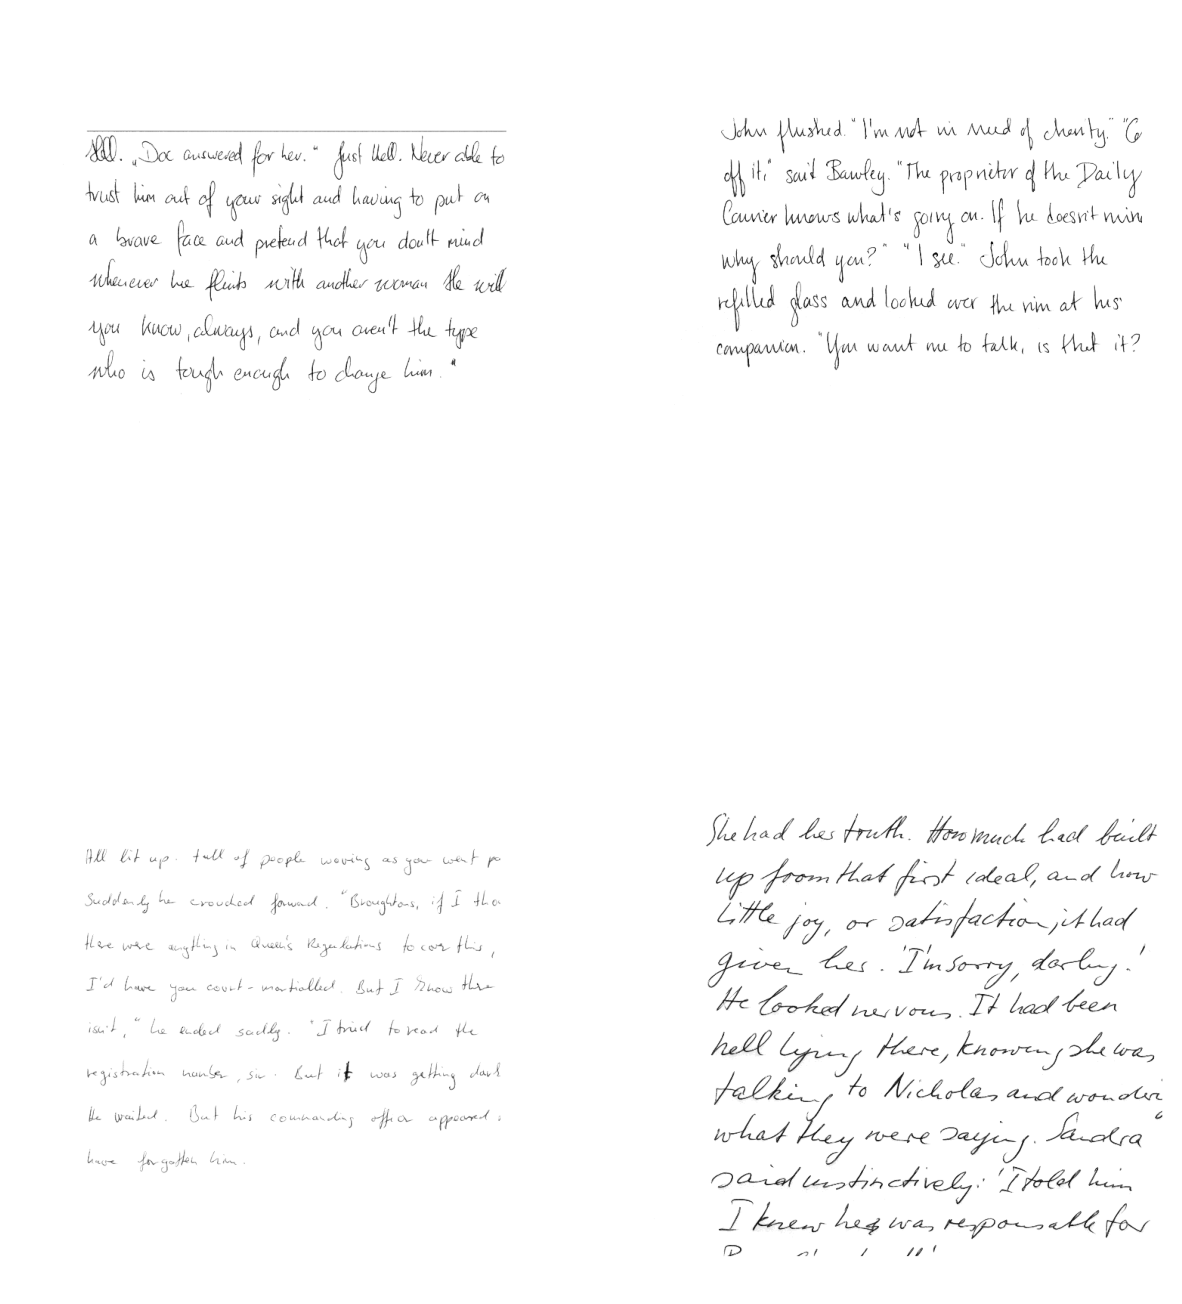

In [ ]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)

    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    if(i==0):
        final_image=image

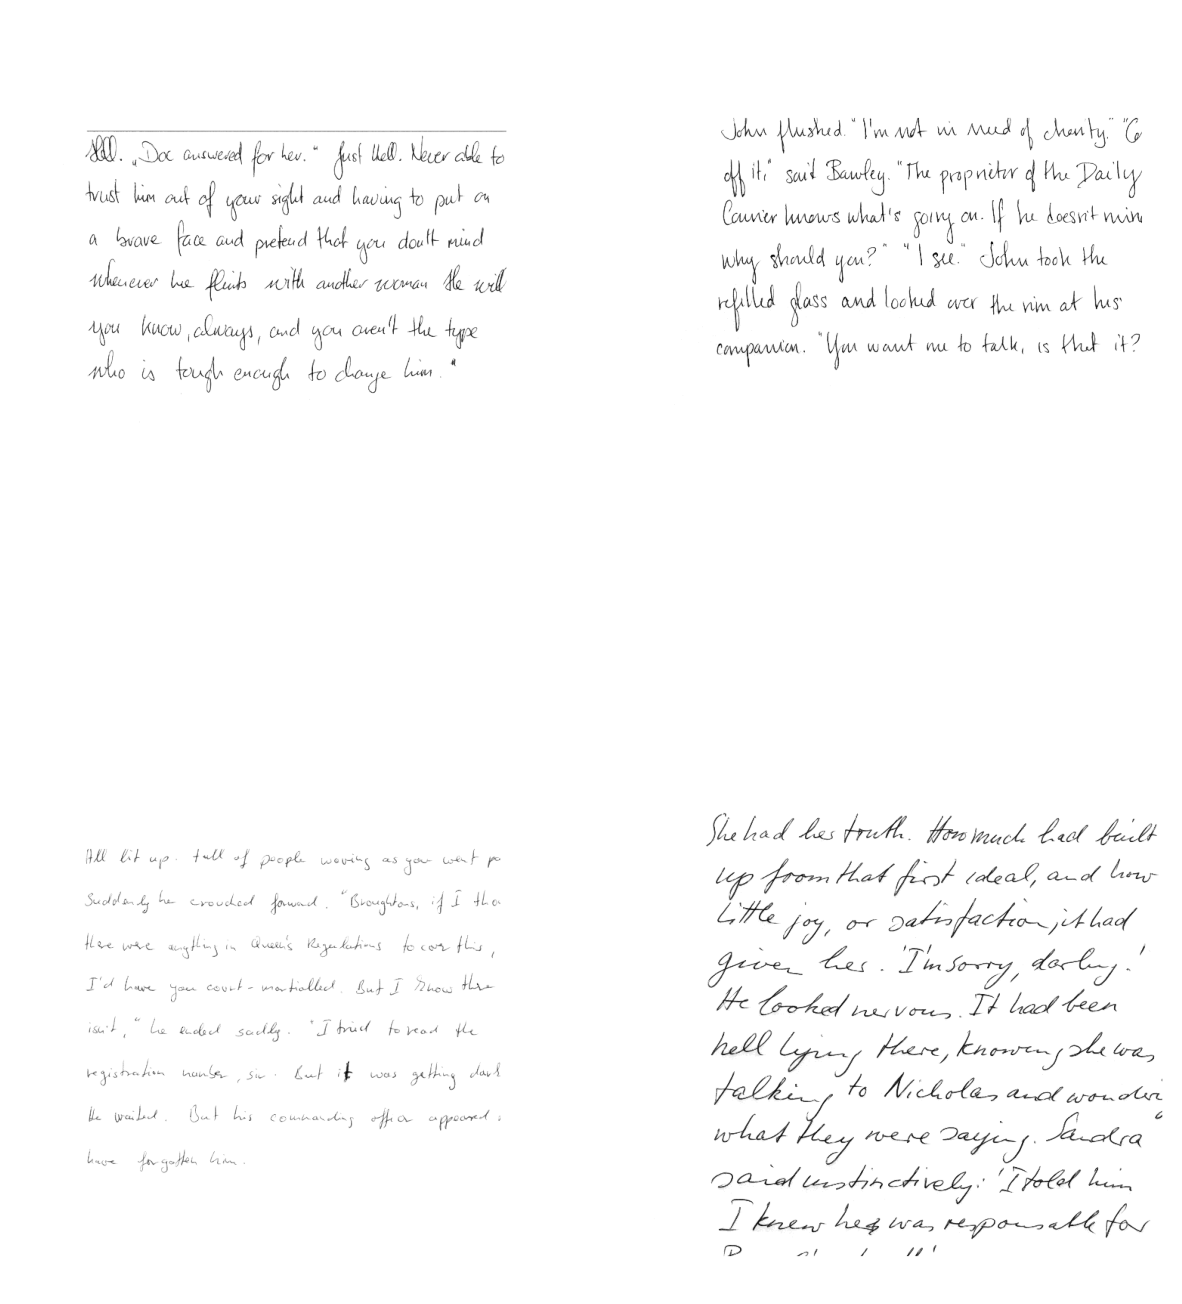

In [ ]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)

    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    if(i==0):
        final_image=image

# 7. Load Word Segmentation model

In [ ]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("/content/drive/MyDrive/Final Year Project/Parameters/ssd_word.params")
#word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()

# 8. Run Word Segmentation on test images

In [ ]:
xi, yi = [], []

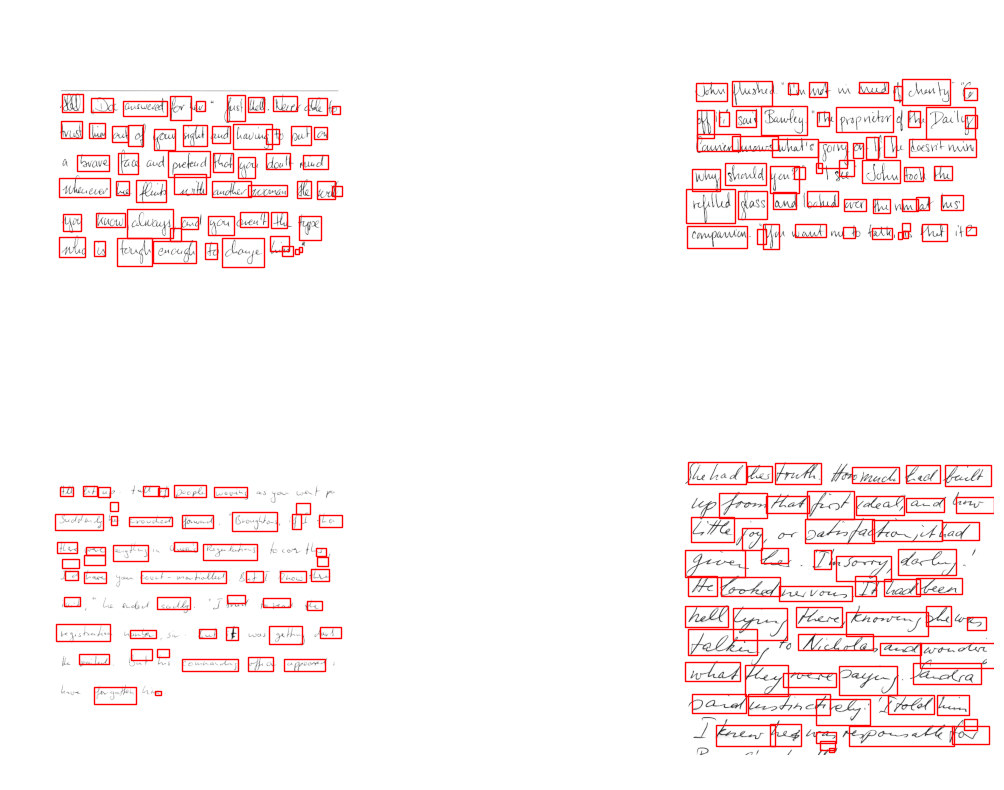

In [ ]:
min_c = 0.1
overlap_thres = 0.1
topk = 600

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2,
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

    predicted_words_bbs_array.append(predicted_bb)

    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        if i==3:
          xi.append(x)
          yi.append(y)
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

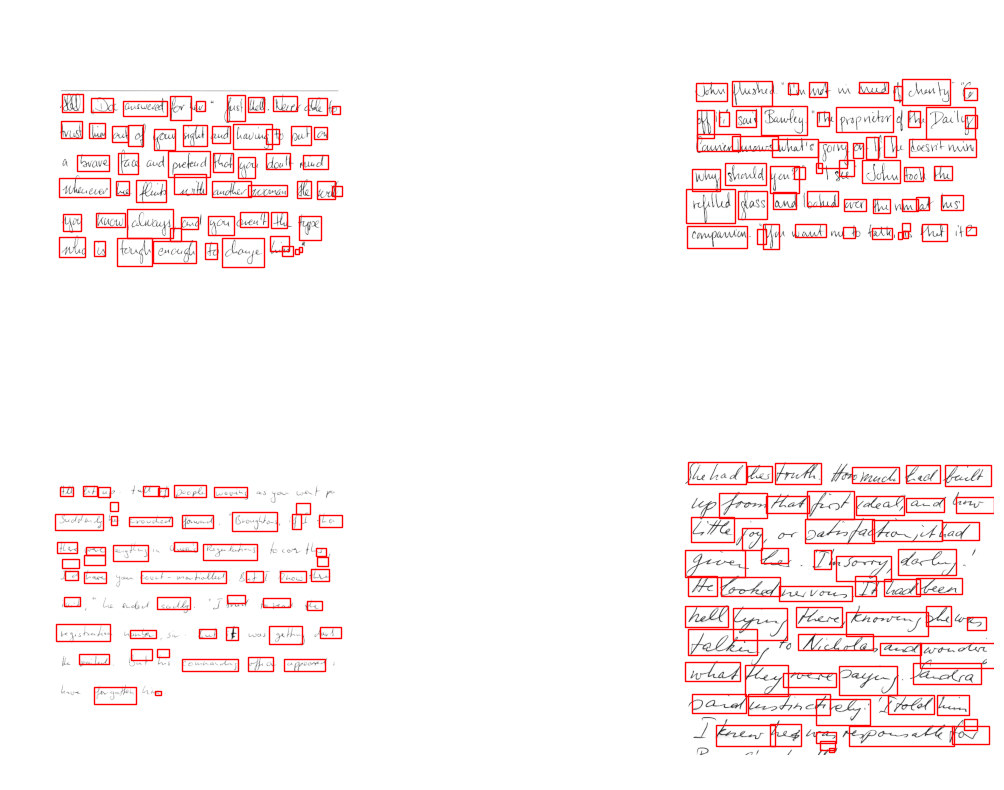

In [ ]:
min_c = 0.1
overlap_thres = 0.1
topk = 600

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2,
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

    predicted_words_bbs_array.append(predicted_bb)

    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

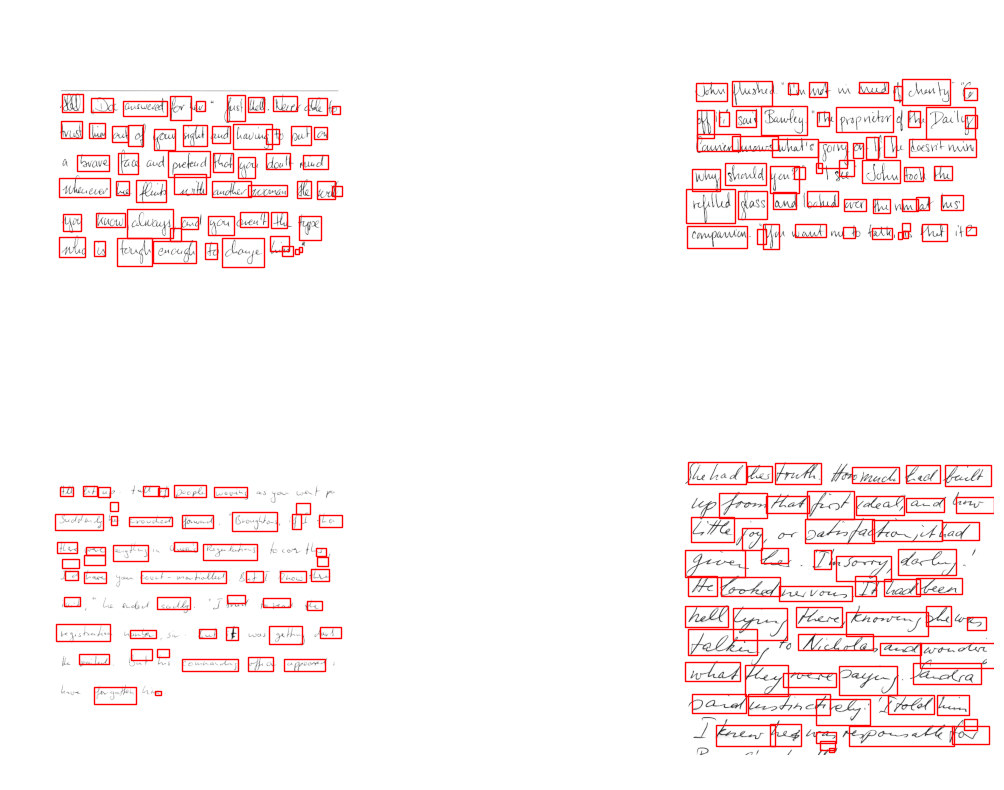

In [ ]:
min_c = 0.1
overlap_thres = 0.1
topk = 600

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2,
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

    predicted_words_bbs_array.append(predicted_bb)

    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

# **Digitize**


In [ ]:
import numpy as np
from PIL import Image as im

data = im.fromarray(paragraph_segmented_image)
data.save('gfg_dummy_pic.png')

In [ ]:
from PIL import Image
from PIL import ImageDraw

In [ ]:
img = Image.open('gfg_dummy_pic.png')

# Call draw Method to add 2D graphics in an image
I1 = ImageDraw.Draw(img)

for i in range(len(xi)):
  I1.text((28, 36), "nice Car", fill=(255, 0, 0))
# Display edited image
img.show()

TypeError: color must be int or single-element tuple

In [ ]:
img.save("car2.png")

# 9. Convert to Line Segmentation

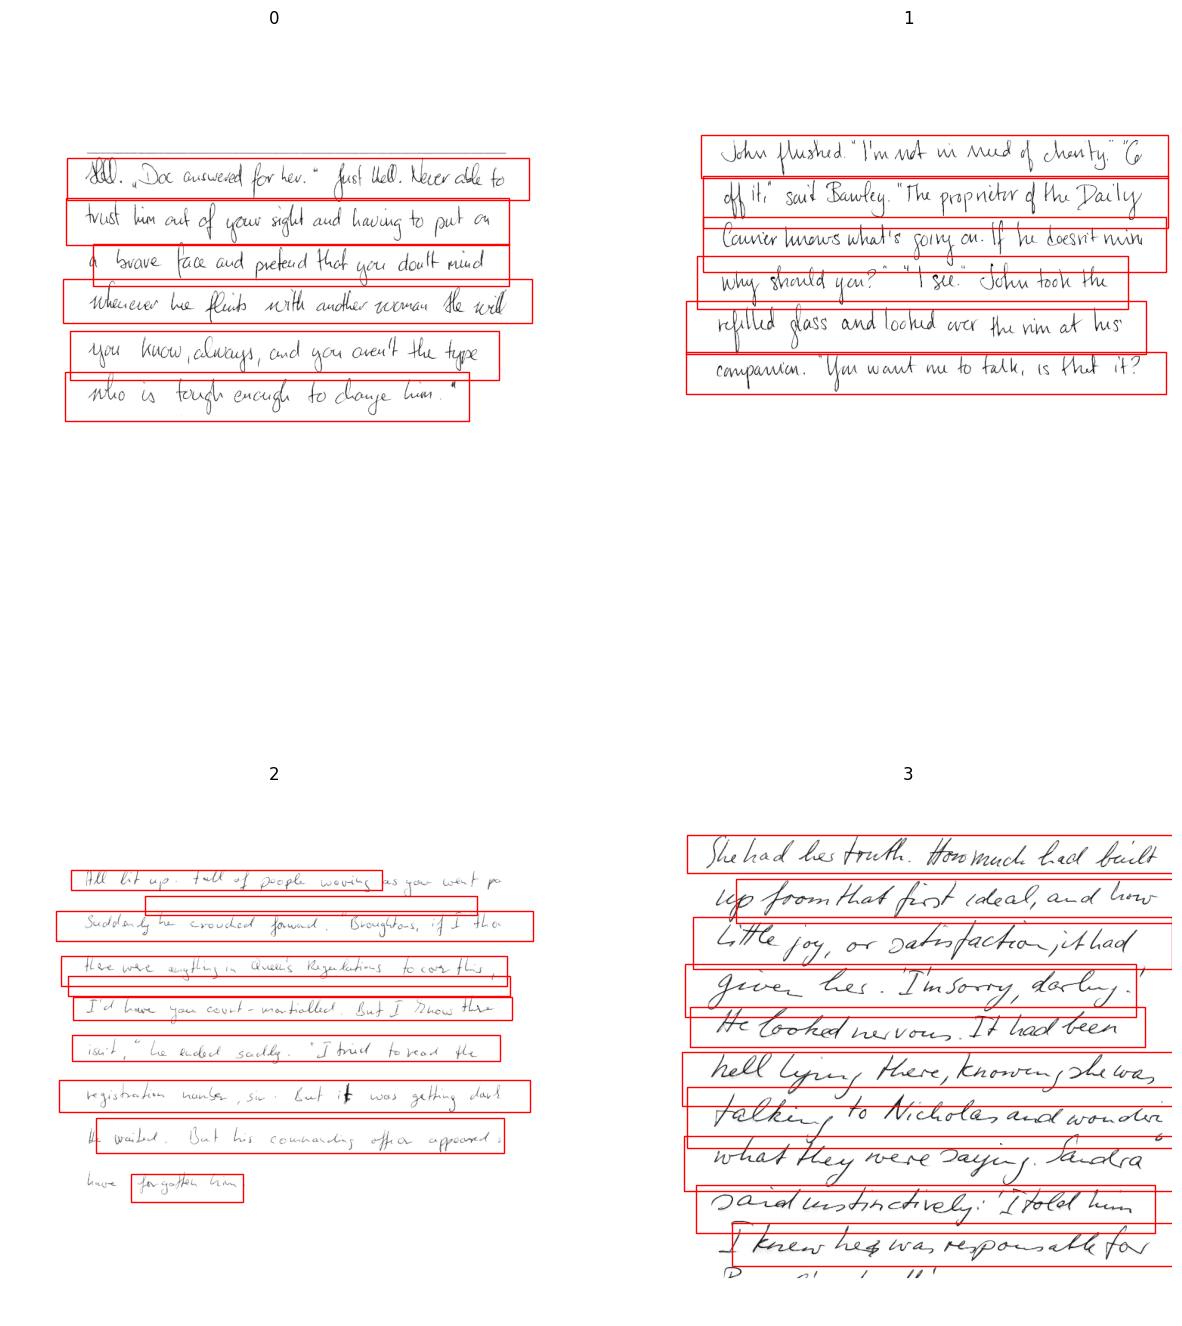

In [ ]:
line_images_array = []
line_images_0=[]
line_images_1=[]
line_images_2=[]
line_images_3=[]
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2,
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    axs[s_y, s_x].set_title("{}".format(i))

    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    if(i==0):
        line_images_0.append(line_images)
    elif(i==1):
        line_images_1.append(line_images)
    elif(i==2):
        line_images_2.append(line_images)
    elif(i==3):
        line_images_3.append(line_images)


    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)

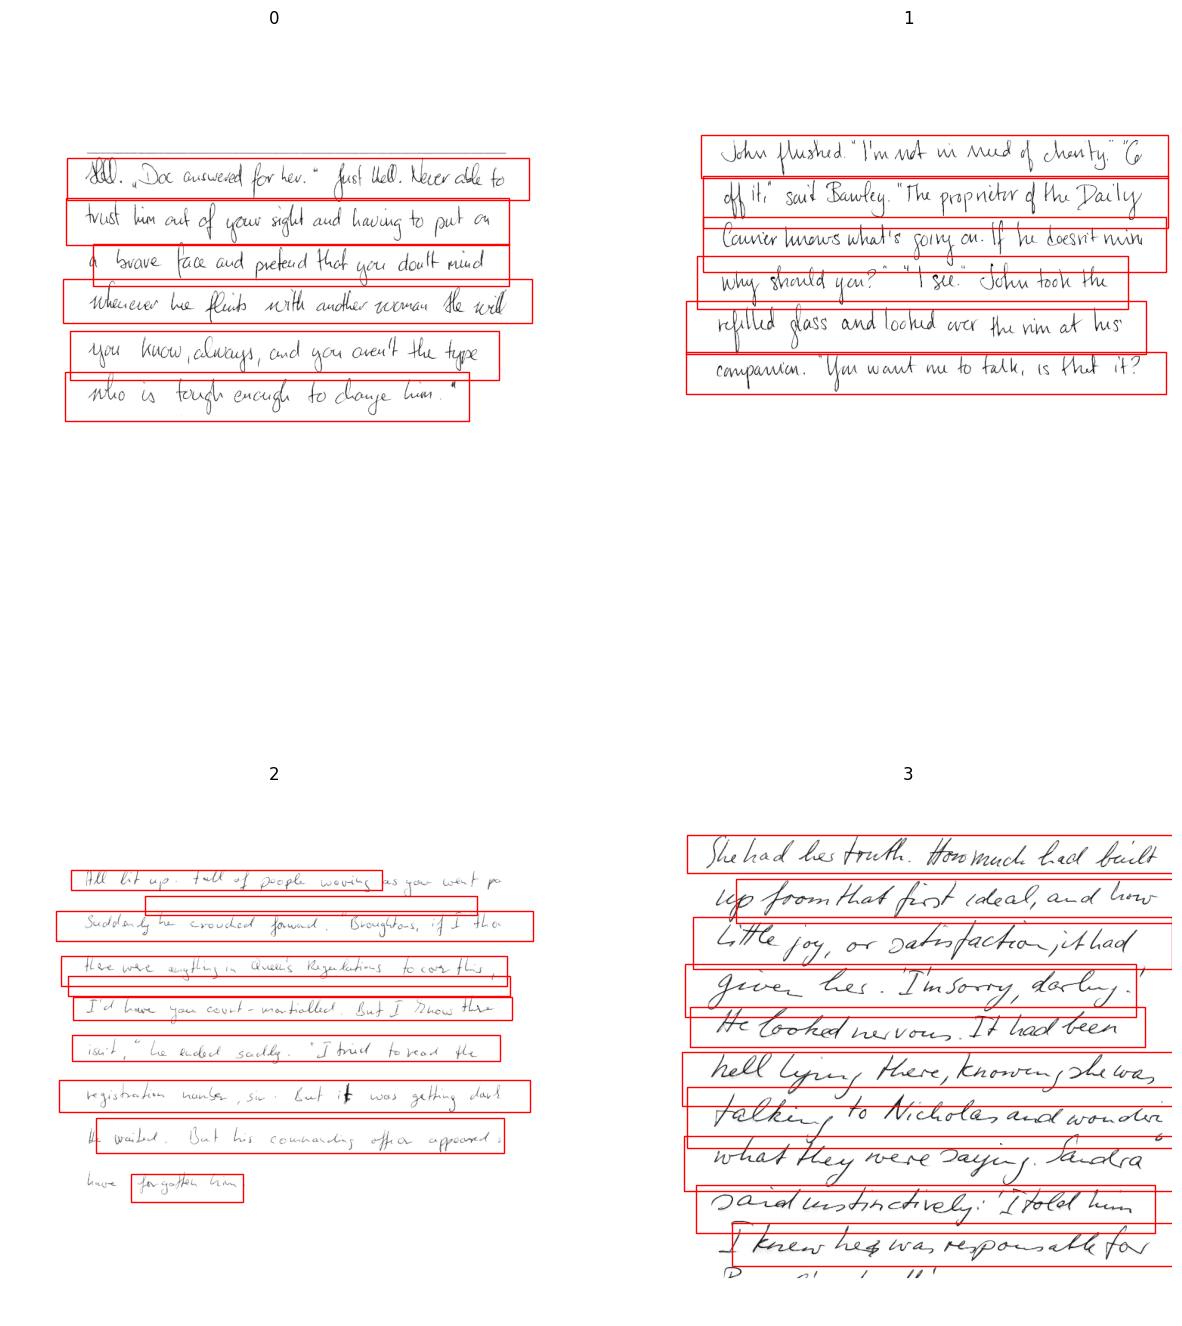

In [ ]:
line_images_array = []
line_images_0=[]
line_images_1=[]
line_images_2=[]
line_images_3=[]
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2,
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    axs[s_y, s_x].set_title("{}".format(i))

    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    if(i==0):
        line_images_0.append(line_images)
    elif(i==1):
        line_images_1.append(line_images)
    elif(i==2):
        line_images_2.append(line_images)
    elif(i==3):
        line_images_3.append(line_images)


    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)

# 10. Load Handwriting Recognition Model

In [ ]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("/content/drive/MyDrive/Final Year Project/Parameters/handwriting.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

In [ ]:
line_image_size = (60, 800)
character_probs = []
#for line_images in line_images_array:
total_line_images=[line_images_0,line_images_1,line_images_2,line_images_3]
for line_images in line_images_0:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

In [ ]:
def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

In [ ]:
def get_beam_search(prob, width=5):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width)
    return possibilities[0]

# 11. Run Handwriting Recognition on test images

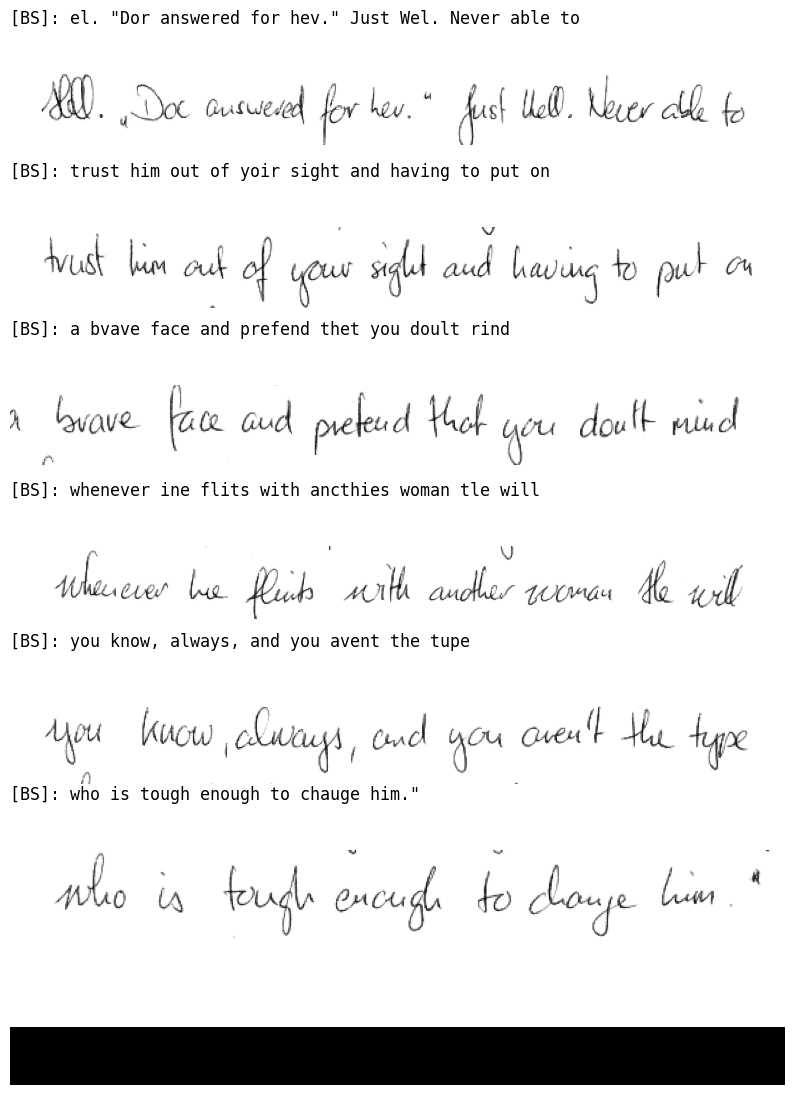

In [ ]:
final_decoded=[]
final_text=""
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1,
                            figsize=(10, int(1 + 2.3 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_bs = get_beam_search(line_character_probs)

        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("[BS]: {}\n\n".format(decoded_line_bs), fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
        axs[j].axis('off')
        #final_decoded.append(decoded_line_bs)
        final_text=final_text+" "+decoded_line_bs


    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

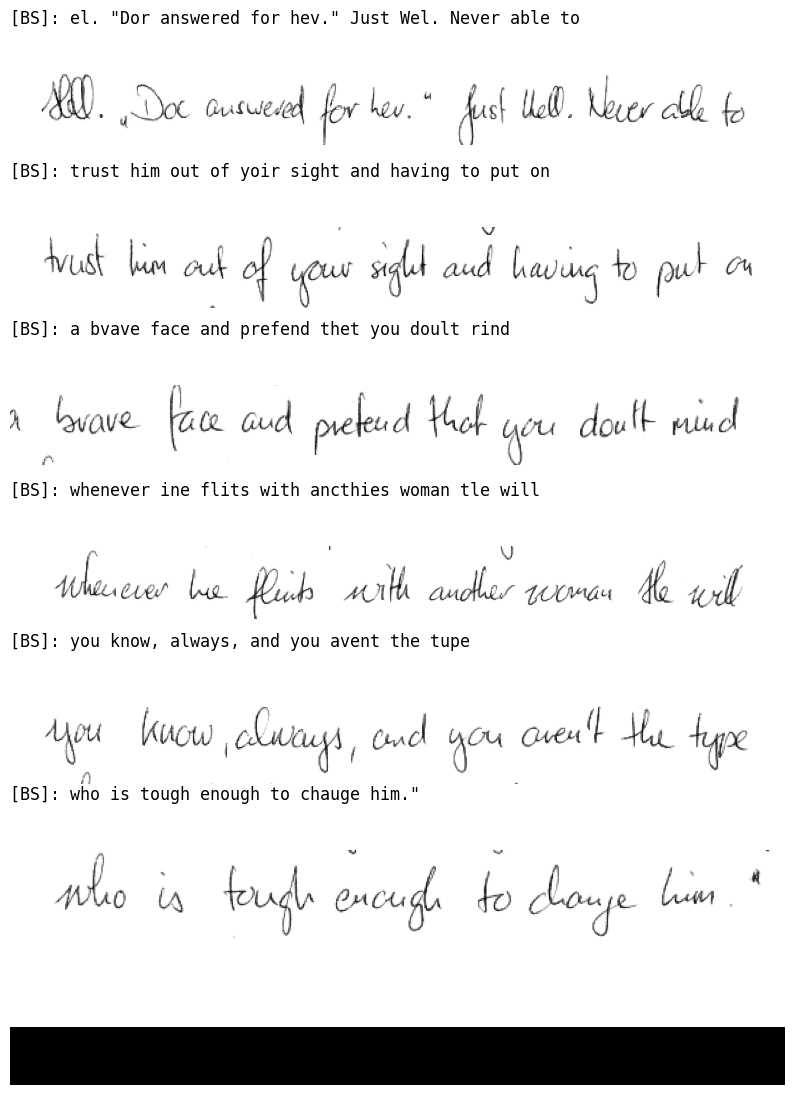

In [ ]:
final_decoded=[]
final_text=""
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1,
                            figsize=(10, int(1 + 2.3 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_bs = get_beam_search(line_character_probs)

        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("[BS]: {}\n\n".format(decoded_line_bs), fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
        axs[j].axis('off')
        #final_decoded.append(decoded_line_bs)
        final_text=final_text+" "+decoded_line_bs


    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

# 12. Compare prediction with Human Insight

 el. "Dor answered for hev." Just Wel. Never able to trust him out of yoir sight and having to put on a bvave face and prefend thet you doult rind whenever ine flits with ancthies woman tle will you know, always, and you avent the tupe who is tough enough to chauge him."


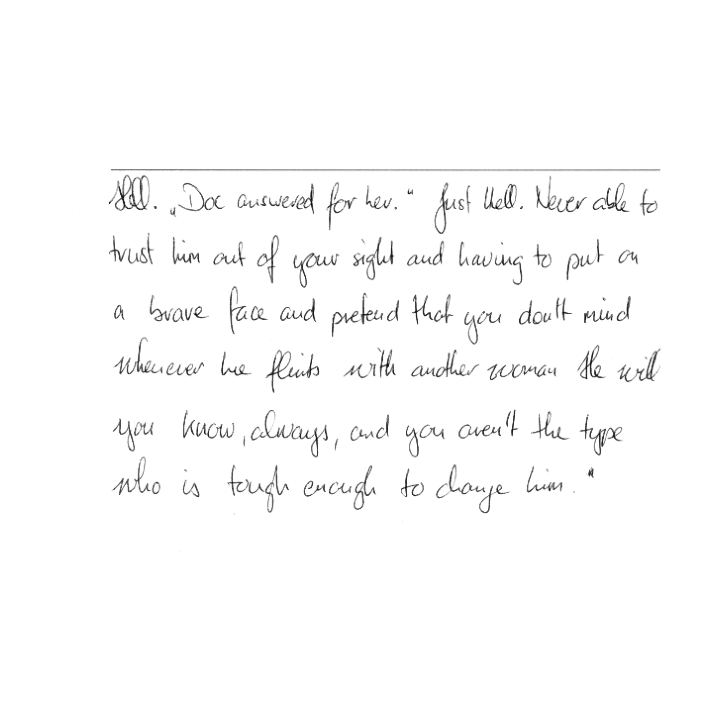

In [ ]:
plt.figure(figsize=(30,9))
plt.imshow(final_image,cmap='Greys_r')
plt.axis('off')
print(final_text)

 el. "Dor answered for hev." Just Wel. Never able to trust him out of yoir sight and having to put on a bvave face and prefend thet you doult rind whenever ine flits with ancthies woman tle will you know, always, and you avent the tupe who is tough enough to chauge him."


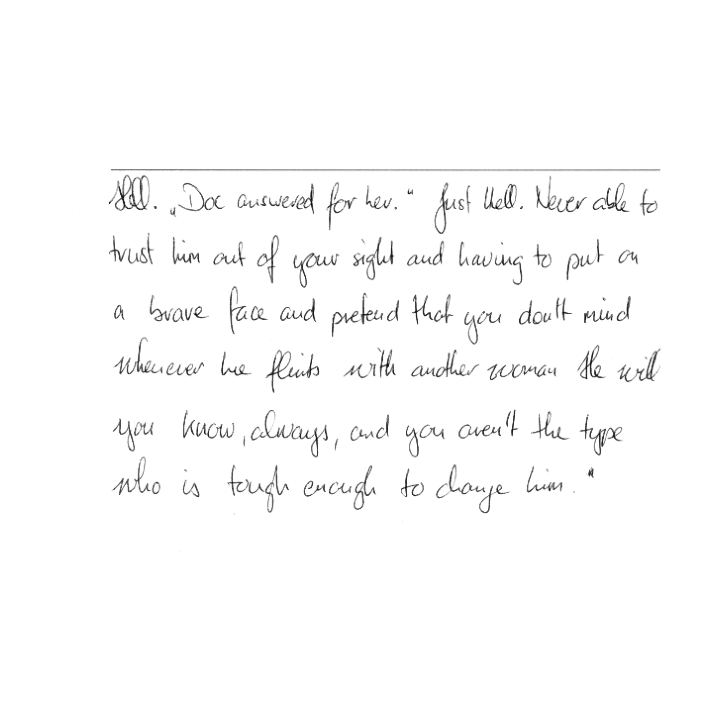

In [ ]:
plt.figure(figsize=(30,9))
plt.imshow(final_image,cmap='Greys_r')
plt.axis('off')
print(final_text)

In [ ]:
from textblob import TextBlob

In [ ]:
sentence = TextBlob(final_text)

In [ ]:
result = sentence.correct()

print(result)

 That it wouldn be her fault at all. That she was a lady who, like her And Chorea, take the highest price in kapingher ward." could see Saunuler 37 ing," he went on in on sores voice, his sunken black eyes tumbling S"He powerful nations, pour Distal Orders. He all know how Falcon poland doengror tall knot of boats, wid close bit, big riches in an out of de worker.
-


In [ ]:
!pip install translate

In [ ]:
!pip uninstall googletrans
!pip install googletrans==3.1.0a0

In [ ]:
!pip install googletrans

from googletrans import Translator, constants
from pprint import pprint

In [ ]:
translator = Translator()
translation = translator.translate('''Searweed's memory was prodigious; her manner must have been worth a great deep to the proper to of the home. The opened form, however, with less than her usual cordiality and flashed a women glance at him. Evidently the other occupant of the bar was not Person later. Of her money was good, so was this strangers. "you' re Commander "inter" he said. "tavern gin"" He turned to Learned''', dest="fr")

In [ ]:
print(translation.text)

La mémoire de Searweed était prodigieuse ; ses manières devaient avoir une grande valeur pour les biens de la maison. La forme ouverte, cependant, avec moins que sa cordialité habituelle et lui lança un regard féminin. De toute évidence, l'autre occupant du bar n'était pas Person plus tard. Son argent était bon, ces étrangers aussi. "Vous êtes le commandant "inter", dit-il. "Tavern gin"" Il se tourna vers Learned.


In [ ]:
translation1 = translator.translate('''Searweed's memory was prodigious; her manner must have been worth a great deep to the proper to of the home. The opened form, however, with less than her usual cordiality and flashed a women glance at him. Evidently the other occupant of the bar was not Person later. Of her money was good, so was this strangers. "you' re Commander "inter" he said. "tavern gin"" He turned to Learned''', dest="hi")

In [ ]:
print(translation1.text)

सीयरवीड की याददाश्त अद्भुत थी; उसका व्यवहार घर के दाहिनी ओर बहुत गहरा रहा होगा। हालाँकि, खुले रूप में उसकी सामान्य सौहार्द्रता से कम और एक महिला की नज़र उस पर पड़ी। जाहिर तौर पर बार में रहने वाला दूसरा व्यक्ति बाद में व्यक्ति नहीं था। उसका पैसा अच्छा था, तो यह पराया भी अच्छा था। "आप' कमांडर हैं "इंटर" उसने कहा। "मधुशाला जिन"" वह विद्वान की ओर मुड़ा


In [ ]:
translation2 = translator.translate('''Searweed's memory was prodigious; her manner must have been worth a great deep to the proper to of the home. The opened form, however, with less than her usual cordiality and flashed a women glance at him. Evidently the other occupant of the bar was not Person later. Of her money was good, so was this strangers. "you' re Commander "inter" he said. "tavern gin"" He turned to Learned''', dest="ml")

In [ ]:
print(translation2.text)

Searweed-ൻ്റെ ഓർമ്മകൾ അതിശയകരമായിരുന്നു; അവളുടെ പെരുമാറ്റം വീടിനു യോജിച്ച ആഴത്തിൽ വളരെ വിലപ്പെട്ടതായിരിക്കണം. തുറന്ന രൂപം, എന്നിരുന്നാലും, അവളുടെ സാധാരണ സൗഹാർദ്ദത്തേക്കാൾ കുറവും, ഒരു സ്ത്രീ അവനെ നോക്കുകയും ചെയ്തു. ബാറിലെ മറ്റേയാളും പിന്നീട് വ്യക്തിയായിരുന്നില്ല. അവളുടെ പണം നല്ലതായിരുന്നു, ഈ അപരിചിതനും. "നിങ്ങൾ" കമാൻഡർ "ഇൻ്റർ" അവൻ പറഞ്ഞു. "ടവേർൺ ജിൻ"" അവൻ ലേണിലേക്ക് തിരിഞ്ഞു


In [ ]:
translation3 = translator.translate('''Searweed's memory was prodigious; her manner must have been worth a great deep to the proper to of the home. The opened form, however, with less than her usual cordiality and flashed a women glance at him. Evidently the other occupant of the bar was not Person later. Of her money was good, so was this strangers. "you' re Commander "inter" he said. "tavern gin"" He turned to Learned''', dest="mr")

In [ ]:
print(translation3.text)

सीअरवीडची स्मृती विलक्षण होती; तिची पद्धत घराच्या योग्यतेसाठी खूप मोलाची असावी. उघडलेला फॉर्म, तथापि, तिच्या नेहमीपेक्षा कमी सौहार्दपूर्ण आणि एक स्त्री त्याच्याकडे पाहत होती. स्पष्टपणे बारचा दुसरा रहिवासी नंतर व्यक्ती नव्हता. तिचे पैसे चांगले होते, म्हणून हे अनोळखी होते. "तू कमांडर आहेस "इंटर" तो म्हणाला. "टेवर्न जिन"" तो शिकलेल्याकडे वळला


In [ ]:
translation4 = translator.translate('''Searweed's memory was prodigious; her manner must have been worth a great deep to the proper to of the home. The opened form, however, with less than her usual cordiality and flashed a women glance at him. Evidently the other occupant of the bar was not Person later. Of her money was good, so was this strangers. "you' re Commander "inter" he said. "tavern gin"" He turned to Learned''', dest="zh-tw")

In [ ]:
print(translation4.text)